Destagionalizzazione degli indici estratti da Google Trends

>>> INIZIO SCRIPT FASE 1: Caricamento e Destagionalizzazione GT <<<

Directory di output: 'dati_preparati_fase1'
--- Caricamento Indici GT da: /Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_gt_hybrid_v6_tests.csv ---
Indici GT caricati con successo. Shape: (252, 11)
Prime 5 righe degli indici GT:
            indice_Inflazione_GT_PCA  indice_Tematico_GT  \
2004-01-01                   6.47336            -6.22290   
2004-02-01                   7.37734            -6.12956   
2004-03-01                   5.00085            -7.57409   
2004-04-01                   4.28482            -7.29147   
2004-05-01                   4.28929            -7.35092   

            indice_Termini_Diretti_Purificato  indice_Alimentari_Purificato  \
2004-01-01                            0.80779                      -1.81757   
2004-02-01                            1.83444                      -3.19382   
2004-03-01                           -2.03732                      -3.19382   
2004-04-01          

/Users/tommaso/my_python_env/lib/python3.13/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: Automatic transformation selection cannot be done on a
          series with zero or negative values.
  
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


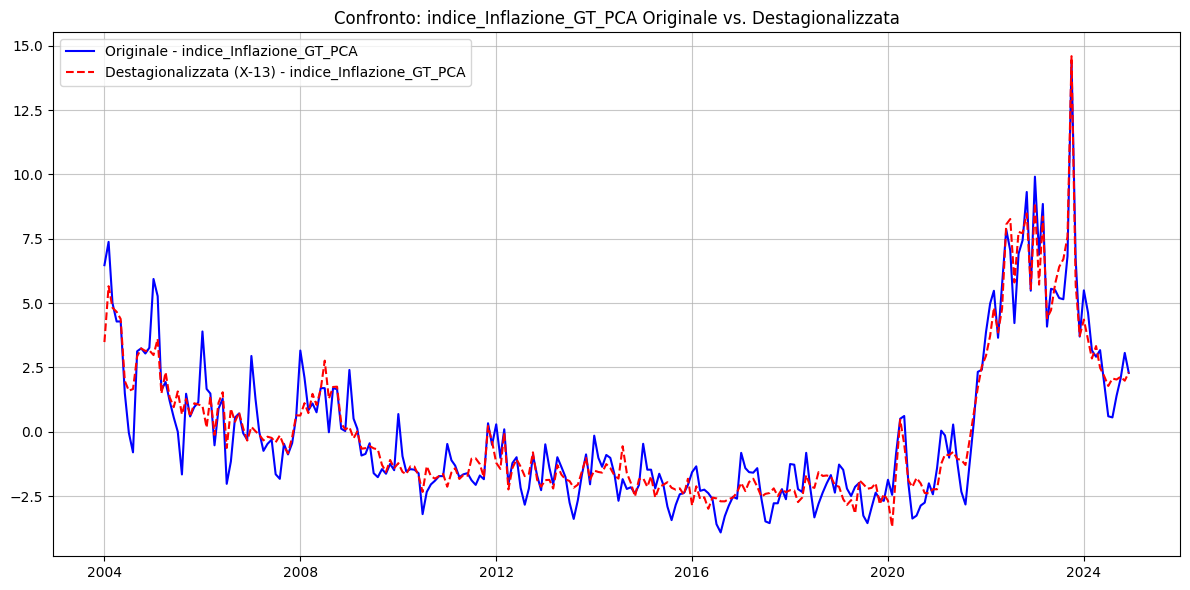

--- Fine Destagionalizzazione X-13 ---

--- Inizio Destagionalizzazione X-13 per: indice_Tematico_GT ---
Uso il path X-13 specificato: /Users/tommaso/bin/x13as
Destagionalizzazione X-13 per 'indice_Tematico_GT' completata.


/Users/tommaso/my_python_env/lib/python3.13/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: Automatic transformation selection cannot be done on a
          series with zero or negative values.
  warn(errors, X13Warning)


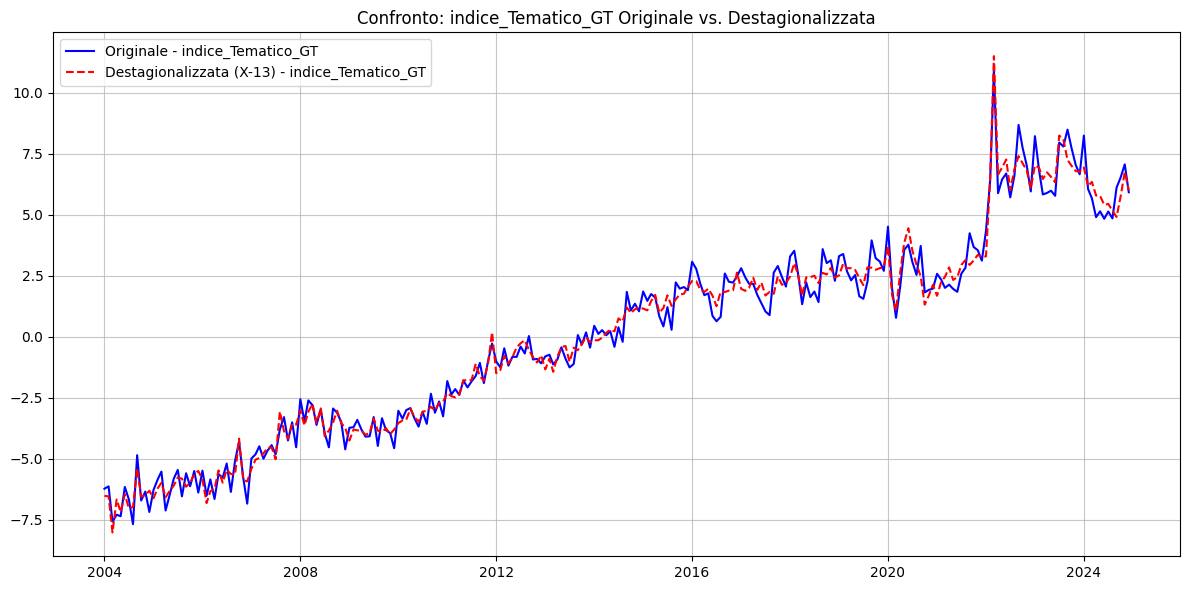

--- Fine Destagionalizzazione X-13 ---

Indici GT originali salvati in: dati_preparati_fase1/indici_gt_originali_fase1.csv
Indici GT (con principali destagionalizzati) salvati in: dati_preparati_fase1/indici_gt_destag_fase1.csv
NIC salvato in: dati_preparati_fase1/nic_fase1.csv

>>> SCRIPT FASE 1 COMPLETATO <<<


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm # Per X-13-ARIMA-SEATS

# --- CONFIGURAZIONE ---
# Path ai file di input
PATH_GT_INDICI = "/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_gt_hybrid_v6_tests.csv"  # File con gli indici GT
PATH_NIC = "/Users/tommaso/Desktop/tesi-inflation-gt/ISTAT_data/NIC_unificato_2004_2024_finale_v3.csv" # File con il NIC

# Path per i file di output
PATH_OUTPUT_DIR = "dati_preparati_fase1" # Creo una sottocartella per l'output
FILE_GT_ORIGINALI_OUT = os.path.join(PATH_OUTPUT_DIR, "indici_gt_originali_fase1.csv")
FILE_GT_DESTAG_OUT = os.path.join(PATH_OUTPUT_DIR, "indici_gt_destag_fase1.csv")
FILE_NIC_OUT = os.path.join(PATH_OUTPUT_DIR, "nic_fase1.csv")

# Colonne degli indici GT principali da destagionalizzare
COLONNE_GT_DA_DESTAG = ['indice_Inflazione_GT_PCA', 'indice_Tematico_GT']

# Il path all'eseguibile X-13 ARIMA SEATS è nel PATH di sistema
# Per evitare che statsmodels non lo trovi, lo specifico direttamente.
# Se volessi che statsmodels provasse a trovarlo automaticamente, scrivo ‘X13_PATH = None’
X13_PATH = "/Users/tommaso/bin/x13as"

# --- FUNZIONI AUSILIARIE ---
def carica_e_prepara_gt(path_file_gt):
    """
    Carico gli indici GT dal CSV e preparo l'indice temporale.
    La colonna A (indice 0) contiene le date, la cella A1 è vuota.
    I nomi delle colonne dati iniziano dalla riga 1.
    """
    print(f"--- Caricamento Indici GT da: {path_file_gt} ---")
    try:
        # Leggo il CSV, la prima colonna è l'indice (date)
        # La cella A1 è vuota, quindi pandas potrebbe non assegnare un nome alla colonna indice.
        # Uso index_col=0 per specificare che la prima colonna è l'indice.
        df_gt = pd.read_csv(path_file_gt, index_col=0)
        
        # Converto l'indice in datetime. Il formato è YYYY-MM-DD.
        df_gt.index = pd.to_datetime(df_gt.index, format="%Y-%m-%d")
        
        # Assicuro che la frequenza dell'indice sia mensile (inizio mese 'MS')
        # Questo è importante per X-13 ARIMA SEATS
        df_gt = df_gt.asfreq('MS')
        
        print(f"Indici GT caricati con successo. Shape: {df_gt.shape}")
        print("Prime 5 righe degli indici GT:")
        print(df_gt.head())
        print(f"Indice temporale: da {df_gt.index.min()} a {df_gt.index.max()}, Frequenza: {df_gt.index.freqstr}")
        print("--- Fine Caricamento Indici GT ---\n")
        return df_gt
    except FileNotFoundError:
        print(f"ERRORE: File non trovato: {path_file_gt}")
        return None
    except Exception as e:
        print(f"ERRORE durante il caricamento degli indici GT: {e}")
        return None

def carica_e_prepara_nic(path_file_nic):
    """
    Carico la serie del NIC e preparo l'indice temporale.
    Colonna A "Periodo" (AAAA-MM), Colonna B "Valore_NIC".
    """
    print(f"--- Caricamento NIC da: {path_file_nic} ---")
    try:
        df_nic = pd.read_csv(path_file_nic)
        
        # Controllo i nomi delle colonne attesi
        if "Periodo" not in df_nic.columns or "Valore_NIC" not in df_nic.columns:
            print("ERRORE: Nomi colonna 'Periodo' o 'Valore_NIC' non trovati nel file NIC.")
            print(f"Colonne trovate: {df_nic.columns.tolist()}")
            return None
            
        # Converto la colonna "Periodo" in datetime e la imposto come indice
        # Il formato è YYYY-MM, pandas lo interpreta come primo giorno del mese.
        df_nic.index = pd.to_datetime(df_nic["Periodo"], format="%Y-%m")
        
        # Seleziono solo la colonna "Valore_NIC" e la rinomino per chiarezza
        df_nic = df_nic[["Valore_NIC"]].rename(columns={"Valore_NIC": "NIC_destag_ISTAT"})
        
        # Assicuro che la frequenza dell'indice sia mensile (inizio mese 'MS')
        df_nic = df_nic.asfreq('MS')
        
        print("NIC caricato con successo.")
        print("Prime 5 righe del NIC:")
        print(df_nic.head())
        print(f"Indice temporale: da {df_nic.index.min()} a {df_nic.index.max()}, Frequenza: {df_nic.index.freqstr}")
        print("--- Fine Caricamento NIC ---\n")
        return df_nic
    except FileNotFoundError:
        print(f"ERRORE: File non trovato: {path_file_nic}")
        return None
    except Exception as e:
        print(f"ERRORE durante il caricamento del NIC: {e}")
        return None

def destagionalizza_serie_x13(serie_input, nome_serie, x13_path=None):
    """
    Destagionalizzo una singola serie temporale usando X-13-ARIMA-SEATS.
    """
    print(f"--- Inizio Destagionalizzazione X-13 per: {nome_serie} ---")
    serie_pulita = serie_input.dropna() # X-13 non gestisce NaN interni, quindi mi assicuro che non ce ne siano
    
    if serie_pulita.empty:
        print(f"Serie '{nome_serie}' vuota dopo rimozione NaN. Impossibile destagionalizzare.")
        # Restituisco una serie di NaN con l'indice originale per mantenere la struttura
        return pd.Series(np.nan, index=serie_input.index, name=f"{nome_serie}_SA")

    # Verifico che l'indice abbia una frequenza, altrimenti X-13 fallisce
    if getattr(serie_pulita.index, 'freqstr', None) is None:
        print(f"Attenzione: Frequenza indice per '{nome_serie}' non definita. Tento di impostarla a 'MS'.")
        try:
            serie_pulita = serie_pulita.asfreq('MS')
            print(f"Frequenza impostata a 'MS' per '{nome_serie}'.")
        except Exception as e_freq:
            print(f"ERRORE nell'impostare la frequenza per '{nome_serie}': {e_freq}")
            return pd.Series(np.nan, index=serie_input.index, name=f"{nome_serie}_SA")
            
    try:
        # Eseguo X-13, del quale ho specificato il path.
        # Se x13_path è None, statsmodels cerca l'eseguibile nel PATH di sistema.
        # Se l'eseguibile non è installato o non è nel PATH, questo fallirà.
        if x13_path:
            print(f"Uso il path X-13 specificato: {x13_path}")
            risultato_x13 = sm.tsa.x13_arima_analysis(serie_pulita, x12path=x13_path)
        else:
            print("Nessun path X-13 specificato, statsmodels cercherà l'eseguibile.")
            risultato_x13 = sm.tsa.x13_arima_analysis(serie_pulita)
            
        serie_destag = risultato_x13.seasadj
        print(f"Destagionalizzazione X-13 per '{nome_serie}' completata.")
        
        # Grafico di confronto
        plt.figure(figsize=(12, 6))
        plt.plot(serie_pulita.index, serie_pulita, label=f"Originale - {nome_serie}", color='blue')
        plt.plot(serie_destag.index, serie_destag, label=f"Destagionalizzata (X-13) - {nome_serie}", color='red', linestyle='--')
        plt.title(f"Confronto: {nome_serie} Originale vs. Destagionalizzata")
        plt.legend()
        plt.grid(True, alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        print("--- Fine Destagionalizzazione X-13 ---\n")
        # Reindicizzo alla serie input originale per ripristinare eventuali NaN all'inizio/fine
        return serie_destag.reindex(serie_input.index).rename(f"{nome_serie}_SA") 
        
    except FileNotFoundError as e_fnf:
        print(f"ERRORE X-13: Eseguibile X-13 ARIMA SEATS non trovato. {e_fnf}")
        print("Assicurati che sia installato e, se necessario, specifica il path in X13_PATH.")
        return pd.Series(np.nan, index=serie_input.index, name=f"{nome_serie}_SA")
    except ValueError as e_val:
        print(f"ERRORE X-13 (ValueError) per '{nome_serie}': {e_val}")
        print("Questo può accadere se la serie è troppo corta, ha troppi NaN consecutivi, o l'indice non ha frequenza.")
        return pd.Series(np.nan, index=serie_input.index, name=f"{nome_serie}_SA")
    except Exception as e:
        print(f"ERRORE generico durante destagionalizzazione X-13 per '{nome_serie}': {e}")
        return pd.Series(np.nan, index=serie_input.index, name=f"{nome_serie}_SA")

# --- ESECUZIONE SCRIPT FASE 1 ---
if __name__ == "__main__":
    print(">>> INIZIO SCRIPT FASE 1: Caricamento e Destagionalizzazione GT <<<\n")

    # Creo la directory di output se non esiste
    os.makedirs(PATH_OUTPUT_DIR, exist_ok=True)
    print(f"Directory di output: '{PATH_OUTPUT_DIR}'")

    # 1. Carico gli indici GT
    df_gt_originali = carica_e_prepara_gt(PATH_GT_INDICI)

    # 2. Carico il NIC (già destagionalizzato da ISTAT)
    df_nic = carica_e_prepara_nic(PATH_NIC)

    df_gt_destagionalizzati = pd.DataFrame(index=df_gt_originali.index if df_gt_originali is not None else None)

    if df_gt_originali is not None:
        # 3. Destagionalizzo gli indici GT principali
        for col_gt in COLONNE_GT_DA_DESTAG:
            if col_gt in df_gt_originali.columns:
                serie_sa = destagionalizza_serie_x13(df_gt_originali[col_gt], col_gt, x13_path=X13_PATH)
                df_gt_destagionalizzati[serie_sa.name] = serie_sa
            else:
                print(f"Attenzione: Colonna '{col_gt}' non trovata negli indici GT caricati. Skippo destagionalizzazione.")
        
        # Aggiungo le altre colonne GT originali (non destagionalizzate) al df dei destagionalizzati per completezza
        for col_originale in df_gt_originali.columns:
            if col_originale not in COLONNE_GT_DA_DESTAG and col_originale not in df_gt_destagionalizzati.columns:
                df_gt_destagionalizzati[col_originale] = df_gt_originali[col_originale]
        
        # Salvo i DataFrame
        try:
            df_gt_originali.to_csv(FILE_GT_ORIGINALI_OUT)
            print(f"Indici GT originali salvati in: {FILE_GT_ORIGINALI_OUT}")
            df_gt_destagionalizzati.to_csv(FILE_GT_DESTAG_OUT)
            print(f"Indici GT (con principali destagionalizzati) salvati in: {FILE_GT_DESTAG_OUT}")
        except Exception as e_save:
            print(f"ERRORE durante il salvataggio dei file GT: {e_save}")
    else:
        print("Salvataggio file GT non eseguito a causa di errori nel caricamento.")

    if df_nic is not None:
        try:
            df_nic.to_csv(FILE_NIC_OUT)
            print(f"NIC salvato in: {FILE_NIC_OUT}")
        except Exception as e_save_nic:
            print(f"ERRORE durante il salvataggio del file NIC: {e_save_nic}")
    else:
        print("Salvataggio file NIC non eseguito a causa di errori nel caricamento.")

    print("\n>>> SCRIPT FASE 1 COMPLETATO <<<")
